In [1]:
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '..')
import torch
from imageProcessing import *
imgProc = ImageProcessor()

In [2]:
focalLength = 50.0*1920/36.0
cameraXYZ = -1 * np.array([5, 5, -2.5])
cameraXYZ[1] = -1 * cameraXYZ[1]
cameraEuler = np.array([np.pi/4, 1.22173, 0]) # Camera orientation as Euler angles (in radians)

depthImage = "ExampleImages/Depth.exr"
depthImageArray = np.array(cv2.imread(depthImage, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH))
colorImage = "ExampleImages/Color.png"
colorImageArray = np.array(cv2.imread(colorImage))

[imgHeight, imgWidth] = depthImageArray.shape[0:2]
imgProc.principalPointX = (imgWidth - 1) / 2
imgProc.principalPointY = (imgHeight - 1) / 2 

# Call the function with an example depth image file
points = imgProc.depthToWorld(focalLength, cameraXYZ, cameraEuler, depthImageArray, colorImageArray)

In [3]:
focalLength = 50.0*1920/36.0
cameraXYZ = -1 * np.array([-4, 6, 4])
cameraXYZ[1] = -1 * cameraXYZ[1]
cameraEuler = [np.pi/4, -2.44346, 0] # Camera orientation as Euler angles (in radians)

depthImage = "ExampleImages/DepthRear.exr"
depthImageArray = np.array(cv2.imread(depthImage, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH))
colorImage = "ExampleImages/Color2.png"
colorImageArray = np.array(cv2.imread(colorImage))

[imgHeight, imgWidth] = depthImageArray.shape[0:2]
imgProc.principalPointX = (imgWidth - 1) / 2
imgProc.principalPointY = (imgHeight - 1) / 2 

# Call the function with an example depth image file
points2 = imgProc.depthToWorld(focalLength, cameraXYZ, cameraEuler, depthImageArray, colorImageArray)

In [4]:
def plot(points):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(points[:,0].get(), points[:,2].get(), points[:,1].get(), c = (np.array([points[:, 5].get(), points[:, 4].get(), points[:, 3].get()]).transpose().get() / 255))
    ax.set_aspect('equal')
    ax.set_xlabel("X")
    ax.set_ylabel("Z")
    ax.set_zlabel("Y")
    plt.show()

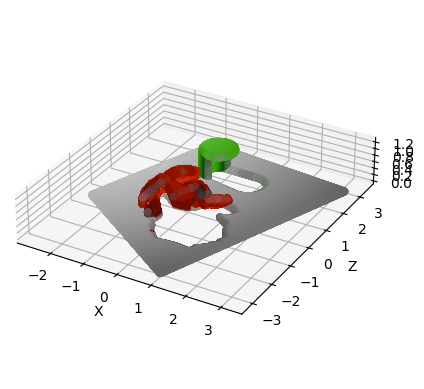

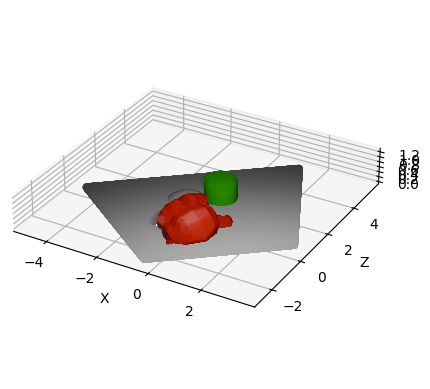

In [5]:
plot(points)
plot(points2)

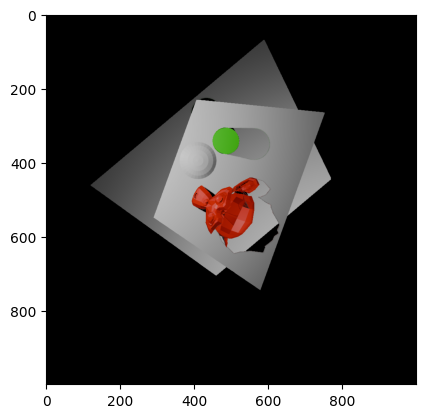

In [6]:
xSize = 1000
ySize = 1000
scale = 80
mapPoints = np.zeros((xSize, ySize, 3))
imgProc.flatten(xSize, ySize, scale, points2, mapPoints)
imgProc.flatten(xSize, ySize, scale, points, mapPoints)
plt.imshow(cv2.cvtColor(mapPoints.astype(np.uint8).get(), cv2.COLOR_BGR2RGB))


0: 640x448 1 person, 1 car, 3 umbrellas, 1 handbag, 1 frisbee, 6 kites, 1 clock, 76.8ms
Speed: 13.0ms preprocess, 76.8ms inference, 92.8ms postprocess per image at shape (1, 3, 640, 448)


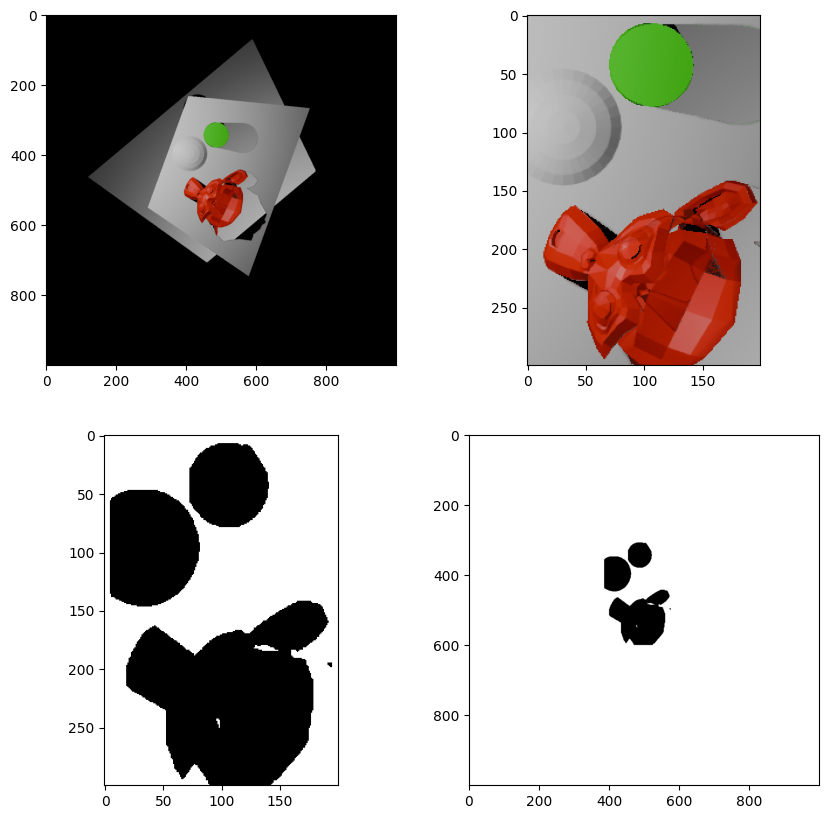

In [7]:
# Get chunk of image for ML Model
posMat = np.array([xSize / 2, ySize / 2, 0])
position = [posMat[0], posMat[1]]
chunkX = 200
chunkY = 300
chunkXOffset = -20
chunkYOffset = -50
model = YOLO('yolov8x-seg.pt')
decreaseByProbability = True
confRequirement = 0.01
printInfo = True
imageChunk = imgProc.getImageChunk(mapPoints, chunkX, chunkY, chunkXOffset, chunkYOffset, position)

# Get costmap of chunk
costChunk = imgProc.detectObjects(imageChunk, model, decreaseByProbability, confRequirement, printInfo)

# Update the costmap
costMap = np.ones((xSize, ySize))
imgProc.updateCostMap(costMap, chunkX, chunkY, costChunk, chunkXOffset, chunkYOffset, position)
fig = plt.figure(figsize=(10, 10)) 
fig.add_subplot(2, 2, 1) 
plt.imshow(cv2.cvtColor(mapPoints[:, :, 0:3].astype(np.uint8).get(), cv2.COLOR_BGR2RGB))
fig.add_subplot(2, 2, 4) 
plt.imshow(cv2.cvtColor(costMap.astype(np.uint8).get() * 255, cv2.COLOR_BGR2RGB))
fig.add_subplot(2, 2, 2) 
plt.imshow(cv2.cvtColor(imageChunk.astype(np.uint8).get(), cv2.COLOR_BGR2RGB))
fig.add_subplot(2, 2, 3) 
plt.imshow(cv2.cvtColor(costChunk.astype(np.uint8).get() * 255, cv2.COLOR_BGR2RGB))